The purpose of this capstone is to determine whether I can learn about train delays using clustering techniques. More specifically, the research question I am seeking to answer is: are clustering technique useful for understanding why trains are delayed? To answer this question, I use a dataset on NJ transit trains (for April 2019), explore the dataset, and apply two different clustering techniques. Finally, I fit two supervised models to compare whether supervised or unsupervised techniques are best for this particular dataset. I hope that the results will be useful for individuals who rely on these trains so that they can better plan their days around when delays are most likely.


In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn import ensemble
from sklearn import svm, datasets
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from scipy.stats.mstats import winsorize
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC 
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Data Exploration

In [2]:
#load dataset
df = pd.read_csv(
    r'C:\Users\Lowe\Documents\Thinkful\Datasets\2019_04.csv')

In [3]:
#look at first 2 rows
df.head(2)

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
0,2019-04-01,4393,1.0,Long Branch,74,Long Branch,74,2019-04-02 00:08:00,2019-04-02 00:07:06,0.00,departed,No Jersey Coast,NJ Transit
1,2019-04-01,4393,2.0,Long Branch,74,Elberon,40,2019-04-02 00:12:00,2019-04-02 00:13:09,1.15,departed,No Jersey Coast,NJ Transit


In [4]:
#get descriptive statistics
df.describe()

,stop_sequence,from_id,to_id,delay_minutes
count,213163.000000,238693.000000,238693.000000,213163.000000
mean,8.200063,4199.830297,4208.931670,3.697638
std,5.108761,11739.567890,11749.484752,4.768392
min,1.000000,1.000000,1.000000,0.000000
25%,4.000000,61.000000,61.000000,1.100000
50%,8.000000,105.000000,105.000000,2.350000
75%,12.000000,137.000000,137.000000,4.916667
max,26.000000,43599.000000,43599.000000,163.000000


In [5]:
#get value count for type of train
df['type'].value_counts()

NJ Transit    226144
Amtrak         12549
Name: type, dtype: int64

Unfortunately, there is no data on delays for the Amtrak trains. I will therefore remove all rows where the type = Amtrak

In [6]:
#drop Amtrak
df2 = df[df.type != 'Amtrak']

In [7]:
#see how the different lines compare along the numeric features
df2.groupby(['type', 'line']).sum()

stop_sequence    from_id      to_id  \
type       line                                                     
NJ Transit Bergen Co. Line         158357.0  132144253  132146512   
           Gladstone Branch        208862.0    1522736    1519076   
           Main Line               183630.0   89855479   89849680   
           Meadowlands Rail             0.0        756     229422   
           Montclair-Boonton       161279.0  103633089  103060414   
           Morristown Line         312836.0   58522461   58523140   
           No Jersey Coast         251005.0  182507864  183717798   
           Northeast Corrdr        236973.0  323297362  324613706   
           Pascack Valley          131640.0   38904132   38905008   
           Princeton Shuttle          729.0      60264      60507   
           Raritan Valley          102639.0   48451129   48445737   

                              delay_minutes  
type       line                              
NJ Transit Bergen Co. Line     70678.500000  
           Gladstone Branch    71237.516667  
           Main Line           70090.533333  
           Meadowlands Rail        0.000000  
           Montclair-Boonton   79425.616667  
           Morristown Line    136207.700000  
           No Jersey Coast    130537.933333  
           Northeast Corrdr   137039.450000  
           Pascack Valley      48218.016667  
           Princeton Shuttle      78.783333  
           Raritan Valley      44685.500000

In [8]:
#get df shape
df2.shape

(226144, 13)

In [9]:
#check missing values
df2.isnull().sum()

date                  0
train_id              0
stop_sequence     12981
from                  0
from_id               0
to                    0
to_id                 0
scheduled_time    12981
actual_time           0
delay_minutes     12981
status                0
line                  0
type                  0
dtype: int64

In [10]:
#look at rows with nulls
pd.options.display.max_rows = 50
null_data = df2[df2.isnull().any(axis=1)]
null_data.head(50)

,date,train_id,stop_sequence,from,from_id,to,to_id,scheduled_time,actual_time,delay_minutes,status,line,type
29,2019-04-01,4367,NaN,Long Branch,74,Long Branch,74,NaN,2019-04-01 19:08:14,NaN,departed,No Jersey Coast,NJ Transit
30,2019-04-01,4367,NaN,Long Branch,74,Elberon,40,NaN,2019-04-01 19:15:09,NaN,departed,No Jersey Coast,NJ Transit
31,2019-04-01,4367,NaN,Elberon,40,Allenhurst,4,NaN,2019-04-01 19:19:16,NaN,departed,No Jersey Coast,NJ Transit
32,2019-04-01,4367,NaN,Allenhurst,4,Asbury Park,8,NaN,2019-04-01 19:23:23,NaN,departed,No Jersey Coast,NJ Transit
33,2019-04-01,4367,NaN,Asbury Park,8,Bradley Beach,22,NaN,2019-04-01 19:25:31,NaN,departed,No Jersey Coast,NJ Transit
34,2019-04-01,4367,NaN,Bradley Beach,22,Belmar,15,NaN,2019-04-01 19:28:28,NaN,departed,No Jersey Coast,NJ Transit
35,2019-04-01,4367,NaN,Belmar,15,Spring Lake,141,NaN,2019-04-01 19:32:33,NaN,departed,No Jersey Coast,NJ Transit
36,2019-04-01,4367,NaN,Spring Lake,141,Manasquan,79,NaN,2019-04-01 19:36:23,NaN,departed,No Jersey Coast,NJ Transit
37,2019-04-01,4367,NaN,Manasquan,79,Point Pleasant Beach,122,NaN,2019-04-01 19:42:10,NaN,departed,No Jersey Coast,NJ Transit
38,2019-04-01,4367,NaN,Point Pleasant Beach,122,Bay Head,13,NaN,2019-04-01 19:47:00,NaN,estimated,No Jersey Coast,NJ Transit


In [11]:
print(null_data['train_id'].nunique())
print(df2['train_id'].nunique())

86
1047


It appears that data on stop sequence, scheduled time, and delay (in minutes) were not collected for certain trains. Since this is the case, it does not make sense to impute values for these missing values. I will have to drop the rows that have missing values. 

In [12]:
#drop missing values
df2=df2.dropna()
df2.isnull().sum()

date              0
train_id          0
stop_sequence     0
from              0
from_id           0
to                0
to_id             0
scheduled_time    0
actual_time       0
delay_minutes     0
status            0
line              0
type              0
dtype: int64

In regard to outliers, it only makes sense to look at delay_minutes because the remaining integer features (e.g., stop sequence, from_id, to_id, etc.) more closely represent categorical data as the integers are used to identify the stop and thus the distance between the values is not meaningful.

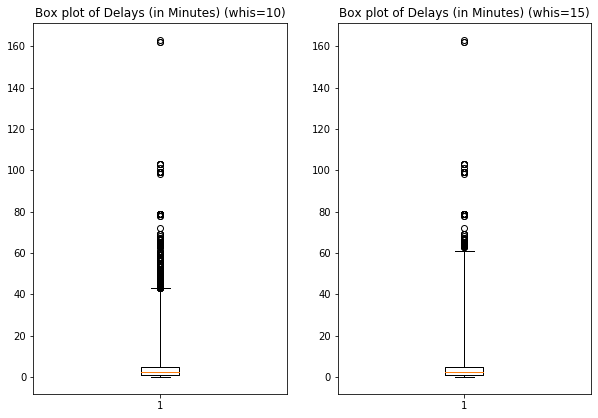

In [13]:
#see if delay_minutes has outliers

fig = plt.figure(figsize=(10,15))
plt.subplot(2, 2, 1)
plt.boxplot(df2["delay_minutes"], whis=10)
plt.title("Box plot of Delays (in Minutes) (whis=10)")
plt.subplot(2, 2, 2)
plt.boxplot(df2["delay_minutes"], whis=15)
plt.title("Box plot of Delays (in Minutes) (whis=15)")
plt.show()

Text(0.5, 0, 'Delay (Minutes)')

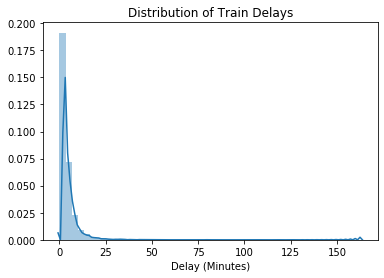

In [14]:
#visualize distribution of delay
sns.distplot(df2['delay_minutes'])
plt.title('Distribution of Train Delays')
plt.xlabel('Delay (Minutes)')

There are a few delays that are far outside the normal range of delays. I will remove the most extreme outliers. Those must have been extreme, unusual events. I will address these outliers to avoid skewing the results.

In [15]:
#winsorize delay_minutes
winsorized_delay_minutes = winsorize(df2["delay_minutes"], (0, 0.005))

df2['winsorized_delay_minutes'] = winsorized_delay_minutes

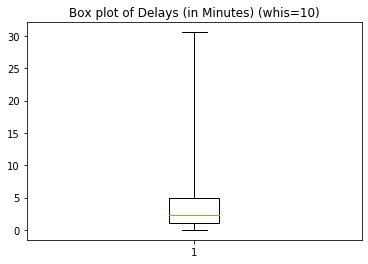

In [16]:
#visualize distribution of delay
plt.boxplot(df2["winsorized_delay_minutes"], whis=10)
plt.title("Box plot of Delays (in Minutes) (whis=10)")
plt.show()

In [17]:
#get max for new feature
df2['winsorized_delay_minutes'].max()

30.5666666667

Text(0.5, 0, 'Delay (Minutes)')

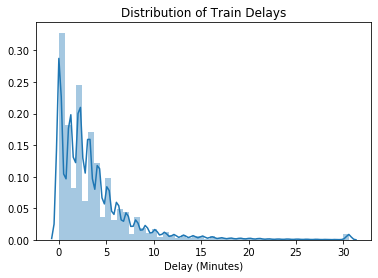

In [18]:
#visualize new distribution of delay
sns.distplot(df2['winsorized_delay_minutes'])
plt.title('Distribution of Train Delays')
plt.xlabel('Delay (Minutes)')

The winsorization removed all datapoints with delays longer than 30 minutes.

In [19]:
#drop original variable
df2 = df2.drop(['delay_minutes'], axis = 1)

Text(0, 0.5, 'Number of Trains')

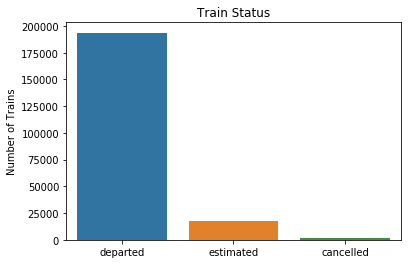

In [20]:
#plot a count of different train statuses
sns.countplot(df2['status'])
plt.title('Train Status')
plt.xlabel('')
plt.ylabel('Number of Trains')

Since I am only interested in trains that actually departed and exploring their delays, I will drop estimated and cancelled.

In [21]:
#drop estimated and cancelled
df2 = df2[df2.status == 'departed']

Later, I will explore whether delays differ by weekday/weekend. I will create a binary variable that measures whether a train departed on a weekend or a weekday.

In [59]:
df2['date'] = pd.to_datetime(df2['date'])
df2['days_of_week']=df2['date'].dt.weekday
df2['weekday'] = (df2['weekday'] < 5).astype(int)

In [33]:
#drop days of week column
df2 = df2.drop(['days_of_week'], axis=1)

In [35]:
#explore average delays
x = df2['winsorized_delay_minutes'] > 0
x = df2.iloc[x.values]
print("The average delay length (minutes) when delay > 0 is {}.".format(x['winsorized_delay_minutes'].mean()))
print("The minimum delay length (minutes) when delay > 0 is {}.".format(x['winsorized_delay_minutes'].min()))
print("The maximum delay length (minutes) when delay > 0 is {}.".format(x['winsorized_delay_minutes'].max()))

The average delay length (minutes) when delay > 0 is 4.051953229728551.
The minimum delay length (minutes) when delay > 0 is 0.0166666666667.
The maximum delay length (minutes) when delay > 0 is 30.5666666667.


Since I am interested in understanding why trains are delayed, I am going to create a binary target variable that measures whether or not a train was delayed. I will use 5 minutes as the threshold for being delayed based on the histogram of delay_minutes. 

In [36]:
#define delay as longer than 5 minutes

df2['long_delay'] = (df2.winsorized_delay_minutes >= 5).astype(int)
#get value count of target variable
df2['long_delay'].value_counts()

0    144512
1     49232
Name: long_delay, dtype: int64

Unfortunately, the dataset is imbalanced. There are 144,512 trains that were not delayed and 49,232 trains that were delayed. 

Text(0, 0.5, 'Number of Trains')

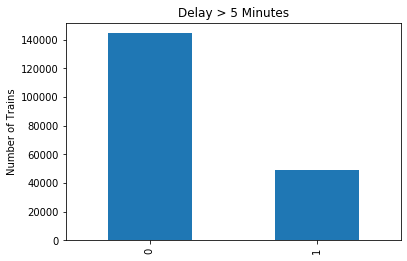

In [37]:
#plot value counts
df2['long_delay'].value_counts().plot(kind='bar')
plt.title('Delay > 5 Minutes')
plt.ylabel('Number of Trains')

I will resample to address the imbalanced dataset issue. 

In [38]:
# Separate majority and minority classes
df_majority = df2[df2.long_delay==0].copy()
df_minority = df2[df2.long_delay==1].copy()
 
# Downsample majority class to a similar size as majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    
                                 n_samples=100000,    
                                 random_state=123)  

df_minority_downsampled = resample(df_minority, 
                                 replace=True,    
                                 n_samples=100000,    
                                 random_state=123) 
 
# Combine minority class with downsampled majority class
df_resampled = pd.concat([df_majority_downsampled, df_minority_downsampled])
 
# Display new class counts
df_resampled.long_delay.value_counts()

1    100000
0    100000
Name: long_delay, dtype: int64

Text(0, 0.5, 'Number of Trains')

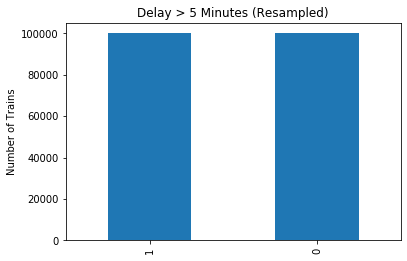

In [39]:
#plot new value counts
df_resampled['long_delay'].value_counts().plot(kind='bar')
plt.title('Delay > 5 Minutes (Resampled)')
plt.ylabel('Number of Trains')

I want to learn more about the data, so I will see which train lines have the most delays (in total) and which train lines have the highest average delays.

Text(0.5, 0, 'Line')

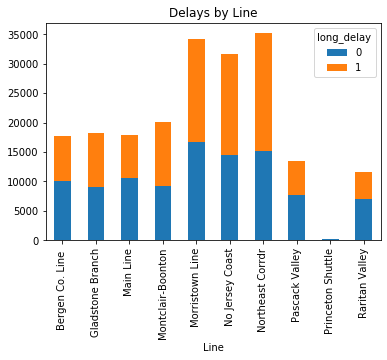

In [40]:
#see which train lines have the most delays
pd.crosstab(df_resampled['line'],df_resampled['long_delay']).plot.bar(stacked=True)
plt.title('Delays by Line')
plt.xlabel('Line')

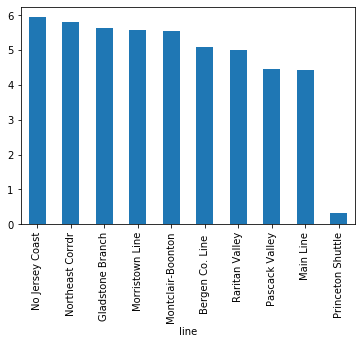

In [42]:
#average delay by train line
df_resampled.groupby('line')['winsorized_delay_minutes'].mean().sort_values(ascending=False).plot(kind='bar')

### Exploring train delays by time of day

It will be interesting to see whether the time of day matters for delays. I will therefore create a variable that categorizes time of day into early morning, morning, afternoon, evening. I create several visualizations to see whether delays vary by time of day.

In [43]:
#see what time of day delays most often occur
#convert to datetime
df_resampled['scheduled_time'] = pd.to_datetime(df_resampled['scheduled_time'])
df_resampled['actual_time'] = pd.to_datetime(df_resampled['actual_time'])


In [44]:
#create a variable for time of day (morning afternoon etc)
df_resampled=df_resampled.assign(
    time=pd.cut(
        df_resampled.scheduled_time.dt.hour,
        [-1,  5, 11, 17, 24],
        labels=['Early Morning','Morning', 'Afternoon', 'Evening']))

Text(0.5, 1.0, 'Scheduled Departure Times')

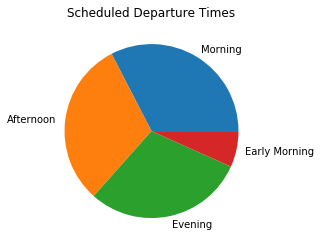

In [46]:
#pie chart for time of day breakdown
df_resampled['time'].value_counts().plot(kind = 'pie')
plt.ylabel('')
plt.title('Scheduled Departure Times')

Text(0.5, 0, 'Time of Day')

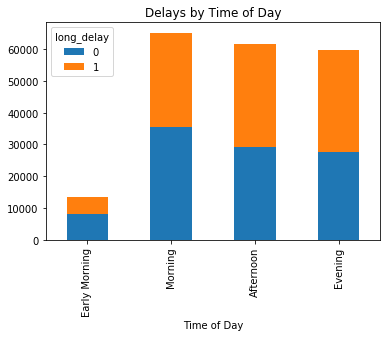

In [47]:
#plot time of day against delays
pd.crosstab(df_resampled['time'],df_resampled['long_delay']).plot.bar(stacked=True)
plt.title('Delays by Time of Day')
plt.xlabel('Time of Day')


Text(0.5, 0, 'Time of Day')

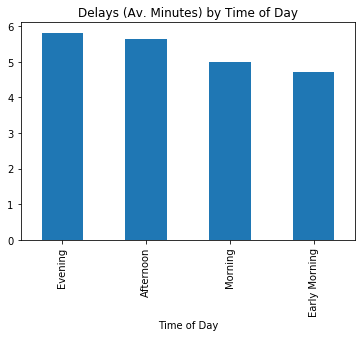

In [48]:
df_resampled.groupby('time')['winsorized_delay_minutes'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Delays (Av. Minutes) by Time of Day')
plt.xlabel('Time of Day')


In [49]:
#average delay (minutes) by time of day
df_resampled.groupby(df_resampled['time'] ,as_index = False )['winsorized_delay_minutes'].mean()

,time,winsorized_delay_minutes
0,Early Morning,4.712188
1,Morning,5.000634
2,Afternoon,5.637863
3,Evening,5.820251


This makes sense, the delays are longer as the day goes on. 

### Comparing train delays by weekends/weekdays 

Text(0, 0.5, 'Number of Delayed Trains')

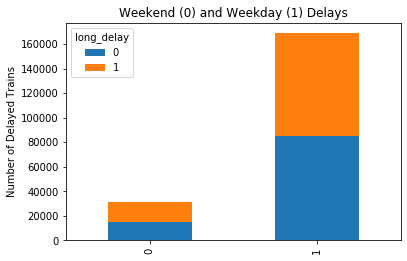

In [69]:
#plot time of day against delays
pd.crosstab(df_resampled['weekday'],df_resampled['long_delay']).plot.bar(stacked=True)
plt.title('Weekend (0) and Weekday (1) Delays')
plt.xlabel('')
plt.ylabel('Number of Delayed Trains')

Text(0, 0.5, 'Average Delay')

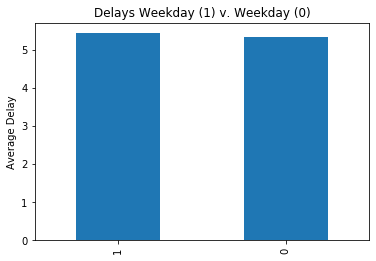

In [68]:
#plot average delays
df_resampled.groupby('weekday')['winsorized_delay_minutes'].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Delays Weekday (1) v. Weekday (0)')
plt.xlabel('')
plt.ylabel('Average Delay')

The average delays are slightly longer on weekdays versus weekends.

Text(0, 0.5, 'Average Delay Minutes')

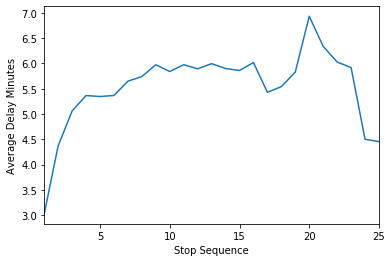

In [53]:
#delays by stop sequence
ax = df_resampled.groupby('stop_sequence')["winsorized_delay_minutes"].mean().plot()
ax.set_xlabel("Stop Sequence")
ax.set_ylabel("Average Delay Minutes")

The above graphic illustrates that trains are more delay as the stop sequence increases. 

In [54]:
#get correlation matrix
df_resampled.corr()

,stop_sequence,from_id,to_id,winsorized_delay_minutes,weekday,weekend,long_delay
stop_sequence,1.000000,-0.112415,-0.020610,0.104086,0.014012,-0.014012,0.152998
from_id,-0.112415,1.000000,-0.077951,0.002803,-0.006289,0.006289,0.003082
to_id,-0.020610,-0.077951,1.000000,0.007339,-0.014453,0.014453,0.003195
winsorized_delay_minutes,0.104086,0.002803,0.007339,1.000000,0.007743,-0.007743,0.682046
weekday,0.014012,-0.006289,-0.014453,0.007743,1.000000,-1.000000,-0.009831
weekend,-0.014012,0.006289,0.014453,-0.007743,-1.000000,1.000000,0.009831
long_delay,0.152998,0.003082,0.003195,0.682046,-0.009831,0.009831,1.000000


In [ ]:
#drop unnecessary columns
df_resampled = df_resampled.drop(['type', 'status', 'scheduled_time', 'actual_time', 'train_id', 'from','to'], axis=1)
df_resampled=df_resampled.drop(['weekend'],axis=1)

# Clustering Techniques

Now, I will explore various clustering techniques to see if clustering can help me learn something meaningful about train delays.

### PCA (for visualization)

In [78]:
#define X and y 
X = df_resampled.drop(['long_delay'], axis = 1).copy()
y = df_resampled['long_delay']
#convert string variables to categorical
list_to_categorical = ['line', 'time', 'date']
for n in list_to_categorical:
    
    X[n] = pd.Categorical(X[n])
    X[n] = X[n].cat.codes


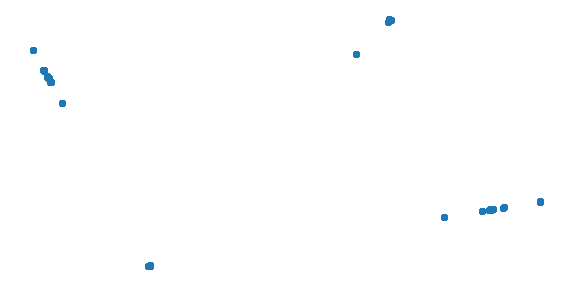

In [79]:
# Use 2 components for two dimensions
pca = PCA(n_components=2)

pca_components = pca.fit_transform(X)

plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

### t-SNE (for visualization)

In [80]:
tsne = TSNE(n_components=2, verbose=False, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

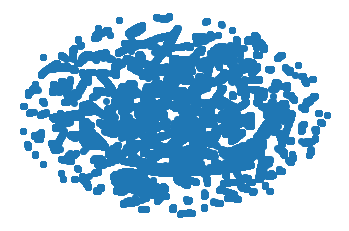

In [81]:
#plot t-SNE 
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

Neither PCA nor t-SNE are very useful in terms of visualizing the clusters. It is very unclear from both plots where the clusters are. This makes me suspect that it will be difficult to learn much about this data using unsupervised techniques, but we will see how K-means, GMM, and DBSCAN perform.

## K Means 

I will apply K-Means to the data, using various k clusters, and analyze the silhouette scores.

In [82]:
# K mean is sensitive to the scale of data, so we standarize:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
#fit k means and get predictions (3-6 cluster solutions)

pred_3 = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
pred_4 = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)
pred_5 = KMeans(n_clusters=5, random_state=123).fit_predict(X_std)
pred_6 = KMeans(n_clusters=6, random_state=123).fit_predict(X_std)
#get silhouette scores for each

print("Silhouette score for three cluster k-means: {}".format(
   metrics.silhouette_score(X_std, pred_3, metric='euclidean')))
print("Silhouette score for four cluster k-means: {}".format(
   metrics.silhouette_score(X_std, pred_4, metric='euclidean')))
print("Silhouette score for five cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_5, metric= 'euclidean')))
print("Silhouette score for six cluster k-means: {}".format(
    metrics.silhouette_score(X_std, pred_6, metric= 'euclidean')))

Silhouette score for three cluster k-means: 0.24531006923096235
Silhouette score for four cluster k-means: 0.16117350150080903
Silhouette score for five cluster k-means: 0.18890371002334544
Silhouette score for six cluster k-means: 0.19990886777192335


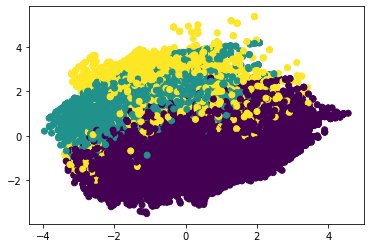

In [84]:
#visualize the k-means 3 cluster solution using 2 PCA components

X_pca = PCA(2).fit_transform(X_std)

# Plot the solution
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_3)
plt.show()

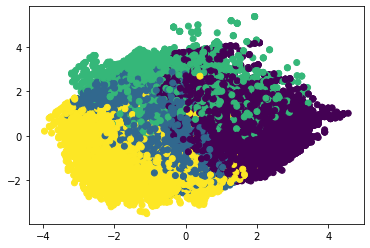

In [85]:
# Plot the 4 cluster solution
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_4)
plt.show()

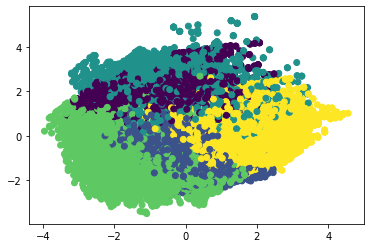

In [86]:
# Plot the 5 cluster solution
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_5)
plt.show()

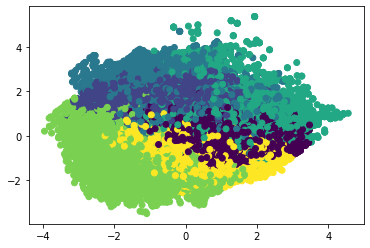

In [87]:
# Plot the 6 cluster solution
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_6)
plt.show()

K-means did okay but not great. The silhouette scores ranged from .17 to .24. I will be able to learn a little about the clusters with these scores but not a ton.

## GMM

In [88]:
# Defining the agglomerative clustering for 3 clusters
gmm_cluster3 = GaussianMixture(n_components=3, random_state=123)

# Fit model
clusters3 = gmm_cluster3.fit_predict(X_std)
#get silhouette score 3 cluster solution
print("Silhouette score for GMM 3 cluster solution: {}".format(
    metrics.silhouette_score(X_std, clusters3, metric='euclidean')))

# Defining the agglomerative clustering for 4 clusters
gmm_cluster4 = GaussianMixture(n_components=4, random_state=123)

# Fit model
clusters4 = gmm_cluster4.fit_predict(X_std)
#get silhouette score 4 cluster solution
print("Silhouette score for  for GMM 4 cluster solution: {}".format(
    metrics.silhouette_score(X_std, clusters4, metric='euclidean')))

# Defining the agglomerative clustering for 5 clusters
gmm_cluster5 = GaussianMixture(n_components=5, random_state=123)

# Fit model
clusters5 = gmm_cluster5.fit_predict(X_std)
#get silhouette score 5 cluster solution
print("Silhouette score for GMM 5 cluster solution: {}".format(
    metrics.silhouette_score(X_std, clusters5, metric='euclidean')))

# Defining the agglomerative clustering for 6 clusters
gmm_cluster6 = GaussianMixture(n_components=6, random_state=123)

# Fit model
clusters6 = gmm_cluster6.fit_predict(X_std)
#get silhouette score 6 cluster solution
print("Silhouette score for GMM 6 cluster solution: {}".format(
    metrics.silhouette_score(X_std, clusters6, metric='euclidean')))


Silhouette score for GMM 3 cluster solution: 0.24531006923096235
Silhouette score for  for GMM 4 cluster solution: 0.2788679542103459
Silhouette score for GMM 5 cluster solution: 0.2201365418613643
Silhouette score for GMM 6 cluster solution: 0.1903539422689957


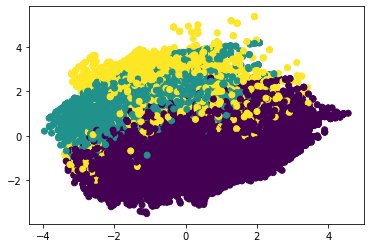

In [90]:
# Plot the solution using 2 PCA components
#3 cluster solution
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters3)
plt.show()

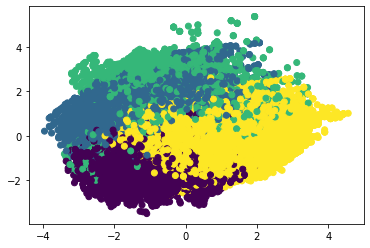

In [91]:
# Plot the 4 cluster solution
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters4)
plt.show()

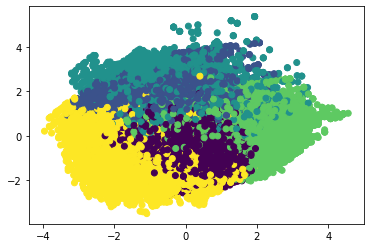

In [92]:
# Plot the 5 cluster solution
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters5)
plt.show()

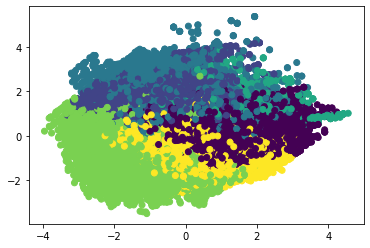

In [93]:
# Plot the 6 cluster solution
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters6)
plt.show()

GMM performed slightly better than K-means, with silhouette scores ranging from .19 to .27. Since GMM also captures the clusters' variances, this tells me that the clusters are not circular and that their variances matter.

## DBSCAN

In [117]:
# Defining the agglomerative clustering
dbscan_cluster1 = DBSCAN(eps=1, min_samples=5)

# Fit model
clusters1 = dbscan_cluster1.fit_predict(X_std)
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(X_std, clusters1, metric='euclidean')))

The silhouette score of the DBSCAN solution: 0.04716317840974263


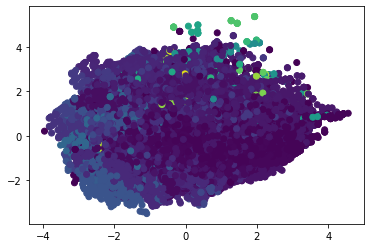

In [118]:
# Plot the solution
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters1)
plt.show()

Due to computational limitations, I was unfortunately unable to run DBSCAN with an epsilon value higher than 1. With the epsilon parameter set to 2 or higher, I immediately ran into memory errors. DBSCAN with parameters set to 1 (epsilon) and 5 (min_samples) did not perform well, with a silhouette score of .047. The plot of the clusters illustrates how poor the clustering is, as you can hardly make out any clusters even with the use of different colors for the different clusters. It is possible that DBSCAN with different parameter values would have been better. 

## Exploring the Clusters

I want to assign labels to the datapoints, so I will use a k-means solution to further explore the clusters to try and pull meaningful information from them so that we can learn why trains are delayed (GMM does not include a labeling attribute). Since there are only small differences between the silhouette scores for the various k-means clustering solutions, I will look more closely at the 5 cluster solution to learn more about the data and clusters.

In [113]:
#re-run K means with 5 clusters
X_std = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)

kmeans.fit(X_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [114]:
#add kmeans predictions to X
X['kmeans_weekday'] = kmeans.labels_
X['kmeans_time'] = kmeans.labels_

Let's see the time of day breakdown per cluster.

Text(0.5, 0, 'K Means Clusters')

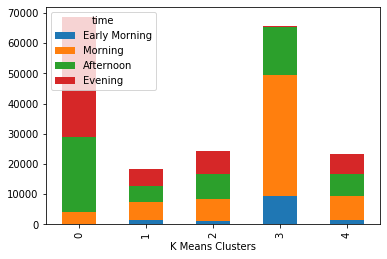

In [115]:
#plot time of day per cluster 
pd.crosstab(X['kmeans_time'],df_resampled['time']).plot.bar(stacked=True)
plt.xlabel('K Means Clusters')

While the clusters are not incredibly meaningful, we can learn a little about train delays based on how k-means clustered the data. Clusters 1, 2, and 4 are fairly similar but clusters 0 and 4 show some differences. Cluster 0 does not include any early morning trains and only includes a very small number of morning trains. Cluster 3 includes a very large number of morning trains, hardly any evening trains, and smaller numbers of early morning and afternoon trains. While not perfect, it seems that k-means included the most delayed trains in cluster 0 and the least delayed trains in cluster 3. Overall, the trains are clustered in a way that suggests there might be slight differences in delays by time of day. The trains that depart in the morning and early morning are less likely to be delayed than trains that depart later in the day. 

Now let's look at the breakdown of weekend vs. weekday per cluster.

Text(0.5, 0, 'K Means Clusters')

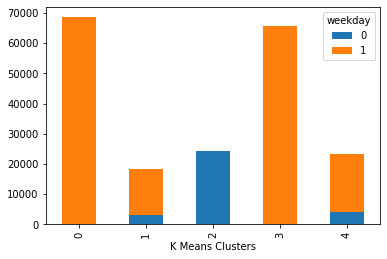

In [116]:
#plot weekend/weekday per cluster
pd.crosstab(X['kmeans_weekday'],df_resampled['weekday']).plot.bar(stacked=True)
plt.xlabel('K Means Clusters')

The k-means 5 cluster solution broken down by weekend/weekday is interesting. Cluster 0 is comprised entirely of weekday trains and zero weekend trains. Cluster 1 includes mostly weekday trains and a few weekend trains. Cluster 2 is comprised of all weekend trains, while cluster 3 is comprised of all weekday trains. Cluster 4 is similar to cluster 1 and includes mostly weekday trains and a few weekend trains. This clustering tells me that weekend/weekday matters in terms of train delays. The trains can certainly be grouped into different clusters based on whether they departed M-F or on a weekend. 

## Supervised Learning

I am interested to see how supervised models compare to the clustering. I first apply PCA even though I do not have a large number of features because it helps with dimensionality reduction and allows me to actually fit these models with a large dataset. With the PCA components, I fit decision tree and logistic regression models. 

Text(0, 0.5, 'Explained Variance')

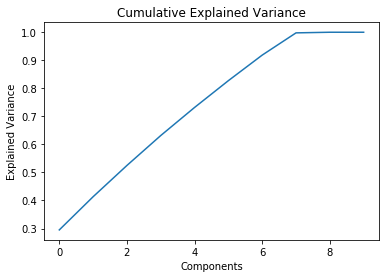

In [104]:
#apply PCA
#standardize and transform X
X_standard = StandardScaler().fit_transform(X)
pca = PCA().fit(X_standard)
#look at variance explained by PCA components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance')
plt.xlabel('Components')
plt.ylabel('Explained Variance')

In [105]:
#use 7 components in PCA
pca = PCA(n_components=7)
X_PCA = pca.fit_transform(X_standard)
#look at explained variance
pca_variance = pca.explained_variance_ratio_
print('Cumulative Explained Variance: ', pca.explained_variance_ratio_.sum())
print('Percentage of total variance explained by each component:',
    pca.explained_variance_ratio_
)

Cumulative Explained Variance:  0.9184692383846151
Percentage of total variance explained by each component: [0.29496634 0.11835948 0.11157195 0.10670129 0.1001632  0.09559486
 0.09111214]


In [106]:
#PCA as a dataframe
PCA_df = pd.DataFrame(X_PCA)
#split data based on PCA
X_train, X_test, y_train, y_test = train_test_split(PCA_df, y, test_size = 0.2, random_state = 465)

## Decision Tree

Before fitting the decision tree, I use grid search CV to find the best parameters. 

In [107]:
#possible parameters
tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90]}
clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5)
clf.fit(X_train, y_train)
#Predict values 
y_pred_dt = clf.predict(X_test)

In [108]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_dt)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_dt)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_dt)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_dt)))
report = classification_report(y_test, y_pred_dt, target_names=['Not Delayed', 'Delayed'])
print(report)
cv_scores_dt = cross_val_score(clf, X_train, y_train, cv = 5)

print('Accuracy scores for the 5 folds: ', cv_scores_dt)
print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores_dt)))
#Confusion matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_dt)))

Accuracy Score : 0.979075
Precision Score : 0.969710445696215
Recall Score : 0.9887147967151998
F1 Score : 0.9791204131015042
              precision    recall  f1-score   support

 Not Delayed       0.99      0.97      0.98     20151
     Delayed       0.97      0.99      0.98     19849

    accuracy                           0.98     40000
   macro avg       0.98      0.98      0.98     40000
weighted avg       0.98      0.98      0.98     40000

Accuracy scores for the 5 folds:  [0.97593825 0.97315625 0.9751875  0.97475    0.97671802]
Mean cross validation score: 0.975
Confusion Matrix : 
[[19538   613]
 [  224 19625]]


## Logistic Regression

I also use gridsearchCV to find the best parameters to use in the logistic regression.

In [109]:
#fit a logistic regression
lrm = LogisticRegression()
#grid search to find best parameters
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_lrm_acc = GridSearchCV(lrm, param_grid = grid_values,scoring = 'recall')
grid_lrm_acc.fit(X_train, y_train)

#Predict values based on best parameters
y_pred_lr = grid_lrm_acc.predict(X_test)

In [110]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_lr)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_lr)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_lr)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_lr)))
report = classification_report(y_test, y_pred_lr, target_names=['Not Delayed', 'Delayed'])
print(report)

cv_scores_lr = cross_val_score(grid_lrm_acc, X_train, y_train, cv = 5)
print('Accuracy scores for the 5 folds: ', cv_scores_lr)
print('Mean cross validation score: {:.3f}'.format(np.mean(cv_scores_lr)))
#Logistic Regression Classifier Confusion matrix

print('Confusion Matrix : \n' + str(confusion_matrix(y_test,y_pred_lr)))

Accuracy Score : 0.86545
Precision Score : 0.8664944013781223
Recall Score : 0.8616051186457756
F1 Score : 0.8640428434294952
              precision    recall  f1-score   support

 Not Delayed       0.86      0.87      0.87     20151
     Delayed       0.87      0.86      0.86     19849

    accuracy                           0.87     40000
   macro avg       0.87      0.87      0.87     40000
weighted avg       0.87      0.87      0.87     40000

Accuracy scores for the 5 folds:  [0.86239162 0.85988771 0.85901435 0.86575172 0.86163444]
Mean cross validation score: 0.862
Confusion Matrix : 
[[17516  2635]
 [ 2747 17102]]


Both supervised models performed well, but the decision tree had significantly better accuracy and precision scores in comparison to the logistic regression. This is to be expected because decision trees perform better with categorical data than logistic regressions do. Even though many of the features in this dataset have integer values, the distance between the values is not very meaningful because they are essentially just identification markers. Therefore, most of the features in this data can be thought of as categorical. A decision tree handles this type of data better because it makes decisions at each node, whereas logistic regressions consider the distance between datapoints (which is not meaningful for most datapoints in this dataset). 

## Summary

From the clustering techniques, we can see that train delays vary based on time of day and weekend/weekday. Passengers can rely on this information to better plan their transportation. For instance, an individual should leave a few minutues early when they rely on evening train transportation to account for the longer delays in that time of day. Also, passengers should take into consideration that train delays are more of an issue during the week as opposed to weekends.  

While it is difficult to directly compare unsupervised vs supervised learning techniques, it is clear from this analysis that the supervised models predicted delays very well. For instance, the decision tree had an accuracy score of 97%. On the other hand, the silhouette scores were fairly low for the clusters, indicating that the clusters were not very dense and that it is not very easy to learn about this particular dataset using clustering techniques. In the future, I would focus on supervised techniques for this dataset.     

In the future, I would like to fit various supervised models without first applying PCA to see which features are most important in predicting delays. I would also like to reduce the dataset to be able to explore the DBSCAN and hierarchical clustering techniques to see if perhaps I could have achieved higher silhouette scores with those techniques. It would also be interesting to compare this dataset (April 2019) to another month to see if the time of year matters in regard to train delays. 